In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from io import BytesIO

ckpt_name = 'aehrc/cxrmate-single-tf'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/a

In [16]:
dataset_dir = '/scratch/pawsey0864/anicolson/datasets'

image_a = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13006587/s56010928/9fde469e-d7898c57-434cb7e8-f995dbf0-883736e5.jpg'))
image_a = image_a.convert('RGB')

image_b = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13087754/s54782563/62d82d85-4baf7437-c86b6818-4afd202f-06f69e52.jpg'))
image_b = image_b.convert('RGB')

image_a = test_transforms(image_a)
image_b = test_transforms(image_b)

images = torch.stack([image_a, image_b], dim=0)
images.shape

torch.Size([2, 3, 384, 384])

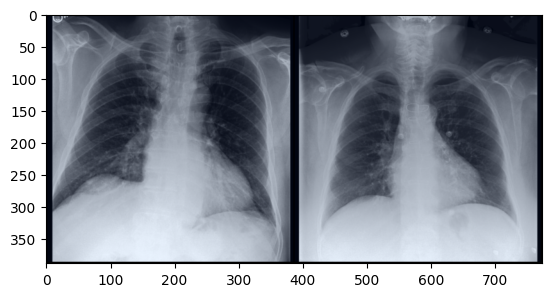

In [17]:
plt.imshow(make_grid(images, normalize=True).permute(1, 2, 0))

In [18]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)

findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)

In [19]:
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: PA and lateral views of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.
Impression: No acute intrathoracic process.

Findings: The patient is status post coronary artery bypass graft surgery. The cardiac, mediastinal and hilar contours appear stable. There is no pleural effusion or pneumothorax. The lungs appear clear.
Impression: No evidence of acute cardiopulmonary disease.

